## Подготовка

Импортируем библиотеки которые могут или понадобяться.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, cross_val_score
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
df.index.is_monotonic

True

Видим, что индексы идут по порядку. Глянем на тублицу. посмотрим распределение и глянем на тип данных.

In [ ]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Все в порядке. Сделаем ресемплирование и приступим к анализу данных в датасете.

In [ ]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

In [ ]:
df_c = df.copy()
decomposed = seasonal_decompose(df_c)

Посмотрим на распределение трендах, сезонность и шумы.

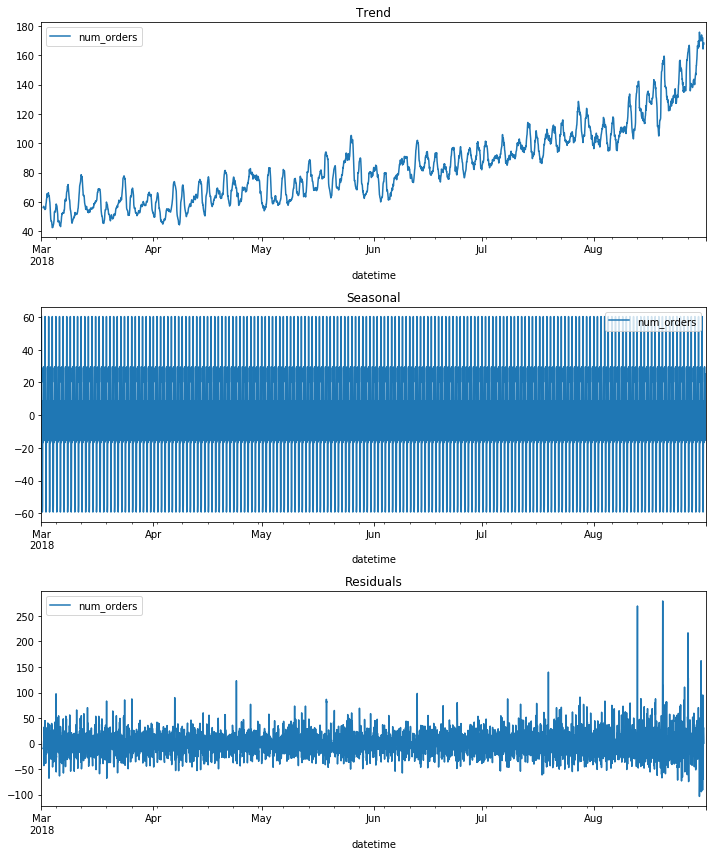

In [ ]:
plt.figure(figsize=(10,12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Глянем на сезонность за более короткий срок тем самым сможем ее видеть.

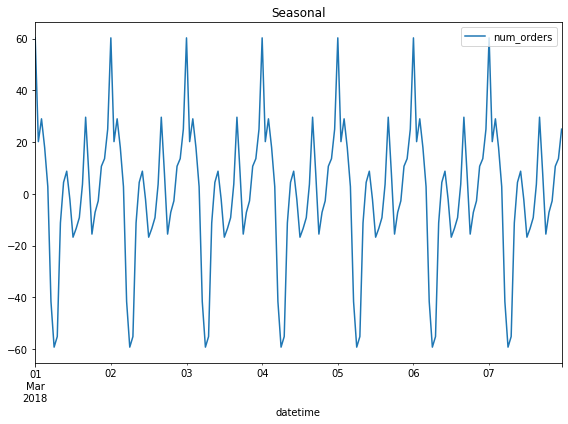

In [ ]:
plt.figure(figsize=(8,6))
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.title('Seasonal')
plt.tight_layout()

Видим, что в трендах растут количество заказов ближе к концу года значит изменяется среднее и график у нас получается не стационраным. Глянем на распределение по часам в месяц.

In [ ]:
df_c['num_orders'] = df_c - df_c.shift()
df_c['rolling_mean'] = df_c['num_orders'].rolling(20).mean()
df_c['std'] = df_c['num_orders'].rolling(20).std()

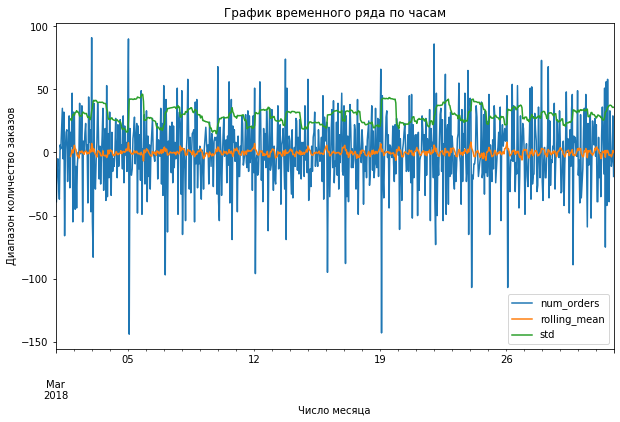

In [ ]:
df_c['2018-03':'2018-03'].plot(figsize=(10,6), title='График временного ряда по часам')
plt.xlabel('Число месяца')
plt.ylabel('Диапазон количество заказов')
plt.show()

Видим, что в течении месяца наш график стационарный, что означает, что он не изменяется и его можно предсказывать. Но если вызвать всю таблицу, то мы увидим, что графиг к концу года изменяется std(оно растет) и он уже нестационарный, хоть и изменения не сильные.

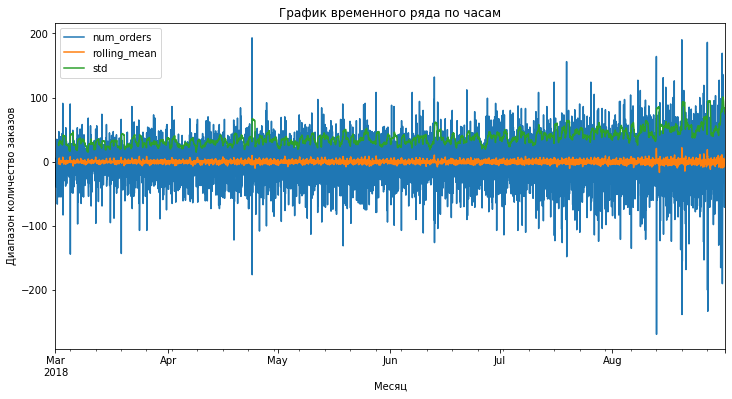

In [ ]:
df_c.plot(figsize=(12,6), title='График временного ряда по часам')
plt.xlabel('Месяц')
plt.ylabel('Диапазон количество заказов')
plt.show()

## Обучение

Напишем функцию создания признаков для временных рядов.

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    new_data['year'] = new_data.index.year
    new_data['month'] = new_data.index.month
    new_data['day'] = new_data.index.day
    new_data['dayofweek'] = new_data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)

    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return new_data
    
new_data = make_features(df, 24, 20)

Разделим на обучающую выборку и тестовую. Создадим признаки и целевой.

In [ ]:
train, test = train_test_split(new_data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
features_test = test.drop(['num_orders'], axis=1)
target_train = train['num_orders']
target_test = test['num_orders']

Выберем модель для обучения с помощью кросс-валидации.

Линейная регрессия

In [ ]:
model = LinearRegression()
tss = TimeSeriesSplit(n_splits=5)
scores = -cross_val_score(model, features_train, target_train, scoring='neg_mean_squared_error',
                         cv=tss)
print('RMSE в линейной регресии:', (scores.mean() ** 0.5).round(2))

RMSE в линейной регресии: 27.22


CatBoost 

In [ ]:
model_cat = CatBoostRegressor(loss_function='RMSE', random_seed=12345)

grid = {'iterations' : [250],
        'learning_rate' : [0.4],
        'depth': [5]
       }

result = model_cat.grid_search(grid, X=features_train, y=target_train, cv=tss)

0:	loss: 34.6781944	best: 34.6781944 (0)	total: 6.24s	remaining: 0us
Estimating final quality...


In [ ]:
model_cat.get_best_score(), model_cat.get_params()

({'learn': {'RMSE': 9.596730152671203}},
 {'loss_function': 'RMSE',
  'random_seed': 12345,
  'depth': 5,
  'iterations': 250,
  'learning_rate': 0.4})

Видим, метрика на CatBoost лучше.

## Тестирование

Проверим нашу модель на тестовой выборке.

In [ ]:
predict = model_cat.predict(features_test)
mse = mean_squared_error(target_test, predict)
r2 = r2_score(target_test, predict)

print("RMSE тестовой выборки: ", mse ** 0.5)
print('R2 тестовой выборки:', r2)

RMSE тестовой выборки:  41.94096075215745
R2 тестовой выборки: 0.4868684172328239


Видим, что RMSE на тестовой выборке 42. Это удовлетворяет ТЗ. R2 показывает адекватность модели. Она почи 50%

Построим график предсказания и настоящих значений.

In [ ]:
data_predict = pd.DataFrame({'target': target_test})

In [ ]:
data_predict['predict'] = predict.round()

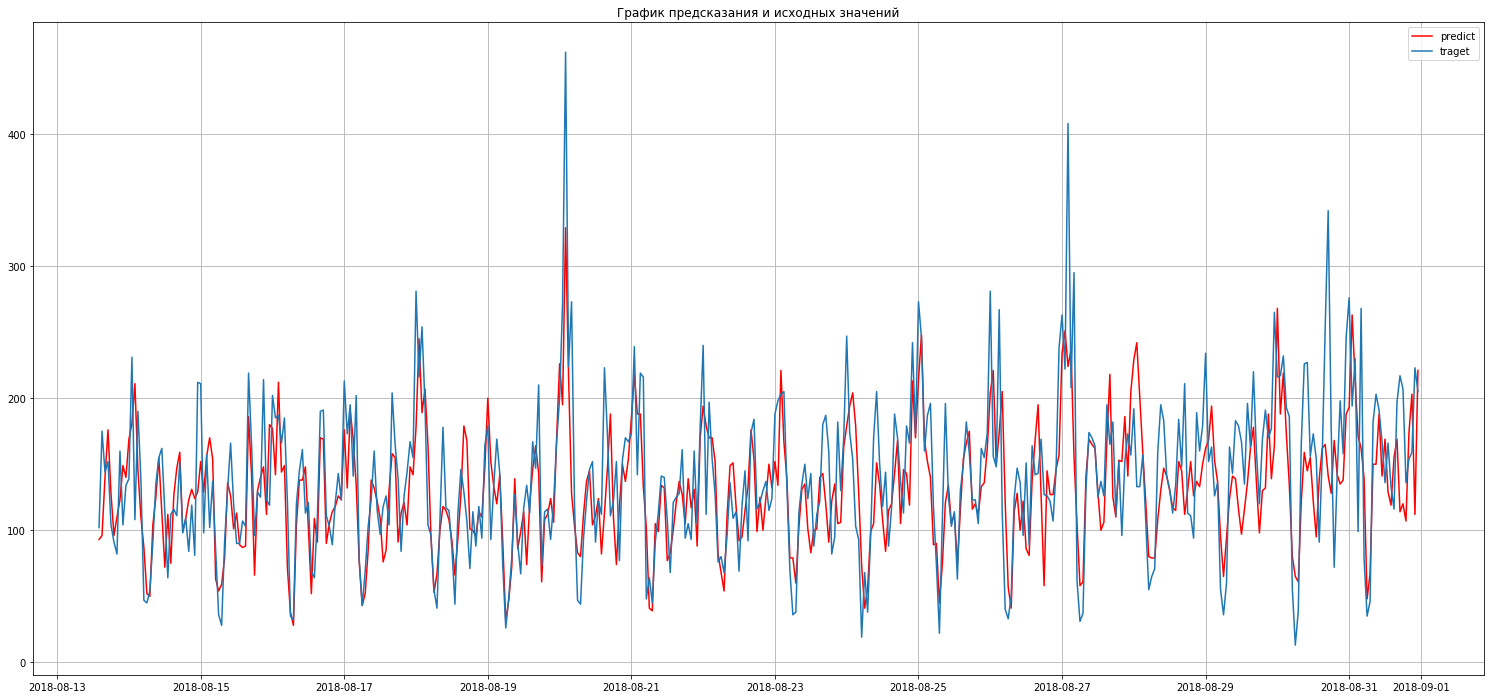

In [ ]:
plt.figure(figsize=(26, 12))
plt.title('График предсказания и исходных значений')
plt.plot(data_predict['predict'], color='r', label="predict")
plt.plot(data_predict['target'], label="traget")
plt.legend()
plt.grid(True)

# Вывод: 

Нужно было предсказать заказы на следующий час. Моя модель показывает, что в среднем она ошибается на 42 заказа в час. Моя ошибка удовлетворяет ТЗ и может делать предсказания для улучшение сервиса в такси.
